Pip installs

Author: Arya Keni, CMPSC 442, SP23, Apr 8 2023, FP: AI and Health 1

In [1]:
!pip install umap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for umap: filename=umap-0.1.1-py3-none-any.whl size=3565 sha256=a09da72e0b07262a4cba638f756122692ef6c9138e66e9e02783c166280c1195
  Stored in directory: /root/.cache/pip/wheels/72/1e/42/a9322736ec046a637487005e6b84c94617d9ac0bdb5159eeb7
Successfully built umap


Imports

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import math
import cv2
import matplotlib.pyplot as plt
import os
import seaborn as sns
import umap
from PIL import Image
from scipy import misc
from os import listdir
from os.path import isfile, join
import numpy as np
from scipy import misc
from random import shuffle
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.utils.np_utils import to_categorical

In [3]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import seaborn as sns
from skimage import color
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

Mount GDrive

In [4]:
from google.colab import drive
drive.mount('/content/drive') #mount google drive for accessing files

Mounted at /content/drive


Check GPU Versioning

In [5]:
device_list=tf.test.gpu_device_name()
print(device_list)
if device_list!="/device:GPU:0": #check if device is GPU for faster training 
    raise SystemError("GPU Device not found")
print("Found GPU at: {}".format(device_list))

/device:GPU:0
Found GPU at: /device:GPU:0


In [8]:
fullpath="/content/drive/MyDrive/Undergraduate/SPRING 2023/CMPSC 442/CMPSC 442 Final Project - Group/Database/brain_tumor_mnist/brain_tumor_dataset/"
fullpath_distinct_no="/content/drive/MyDrive/Undergraduate/SPRING 2023/CMPSC 442/CMPSC 442 Final Project - Group/Database/brain_tumor_mnist/no/"
fullpath_distinct_yes="/content/drive/MyDrive/Undergraduate/SPRING 2023/CMPSC 442/CMPSC 442 Final Project - Group/Database/brain_tumor_mnist/yes/"

#...=??? ###NOTE: Remember to change the paths for all the "/.../.../" in the code, to your own folder paths

yes=os.listdir(fullpath_distinct_yes)
no=os.listdir(fullpath_distinct_no)

Image Checking

In [9]:
im =Image.open(fullpath_distinct_no+'1 no.jpeg').resize((128,128))
print(im)

<PIL.Image.Image image mode=L size=128x128 at 0x7FB24811A520>


In [10]:
im =Image.open(fullpath_distinct_yes+'Y1.jpg').resize((128,128))
print(im)

<PIL.Image.Image image mode=RGB size=128x128 at 0x7FB27D518A00>


In [11]:
data=np.concatenate([yes,no])
print(len(data)==len(yes)+len(no))

True


In [12]:
target_x=np.full(len(yes),1)
target_y=np.full(len(no),0)
data_target=np.concatenate([target_x,target_y])
print(len(data_target)==len(target_x)+len(target_y))

True


In [15]:
print(len(data_target)==len(data)) #verufying if added length is same as all dataset length

True


In [14]:
fullpath_yes_interm=fullpath+"yes/"
fullpath_no_interm=fullpath+"no/"

yes_values=os.listdir(fullpath_yes_interm)
no_values=os.listdir(fullpath_no_interm)

In [16]:
X_data =[]
for file in yes_values:
    #face = misc.imread('../input/brain_tumor_dataset/yes/'+file)
    img = cv2.imread(fullpath_yes_interm+file)
    face = cv2.resize(img, (32, 32) )
    (b, g, r)=cv2.split(face) 
    img=cv2.merge([r,g,b])
    X_data.append(img)

In [17]:
#X_data =[]
for file in no_values:
    #face = misc.imread('../input/brain_tumor_dataset/yes/'+file)
    img = cv2.imread(fullpath_distinct_no+file)
    face = cv2.resize(img, (32, 32) )
    (b, g, r)=cv2.split(face) 
    img=cv2.merge([r,g,b])
    X_data.append(img)

In [18]:
print(len(X_data)==len(data)==len(data_target)) #check if the recombined data is the same as OG

True


In [19]:
X = np.squeeze(X_data)

In [20]:
# normalize data
X = X.astype('float32')
X /= 255

In [21]:
from sklearn.utils import shuffle

In [22]:
X, data_target  =  shuffle(X, data_target) #everything is shuffled, (test, valid, train) #and 1-1 correlated

In [23]:
print(len(data_target))

253


In [24]:
#add percent based indexing on train and test 
p_train=0.8 #0.8 #0.9 #0.75 #0.7 #works well for 0.75-default 
i_train=int(len(data_target)*p_train)
i_valid=len(data_target)-i_train #ideally at 0.8

In [25]:
(x_train, y_train), (x_test, y_test) = (X[:i_train],data_target[:i_train]) , (X[i_train:] , data_target[i_train:])
(x_valid , y_valid) = (x_test[:i_valid], y_test[:i_valid])
#(x_test, y_test) = (x_test[63:], y_test[63:]) #given number set, 75-25, for a set length of total data images, 75% is 190

In [26]:
model = tf.keras.Sequential()

# Must define the input shape in the first layer of the neural network
model.add(tf.keras.layers.Conv2D(filters=16,kernel_size=9, padding='same', activation='relu', input_shape=(32,32,3))) 
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Dropout(0.45))

model.add(tf.keras.layers.Conv2D(filters=16,kernel_size=9,padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Conv2D(filters=36, kernel_size=9, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dropout(0.15))


model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# Take a look at the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 16)        3904      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 16)        20752     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 16)         0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 16)          0

In [27]:
model.compile(loss='binary_crossentropy',
             optimizer=tf.keras.optimizers.Adam(),
             metrics=['acc', 'binary_crossentropy', 'mean_squared_error']) 

#fixed batch due to batching at random, optimal size for the types of images and the data segments and the data images in total.

epochs_values=[50,100,150, 200, 250] 


testable_epoch_idx=2 #0 to 2 incl.  #default at 1, trial at 2

In [28]:
history = model.fit(x_train,
         y_train,
         batch_size=128, 
         epochs=epochs_values[testable_epoch_idx],
         validation_data=(x_valid, y_valid),) #or None for callbacks #none work anyways

Epoch 1/150
2/2 [==============================] - 12s 457ms/step - loss: 0.7189 - acc: 0.4802 - binary_crossentropy: 0.7189 - mean_squared_error: 0.2604 - val_loss: 0.6841 - val_acc: 0.5490 - val_binary_crossentropy: 0.6841 - val_mean_squared_error: 0.2455
Epoch 2/150
2/2 [==============================] - 0s 37ms/step - loss: 0.6418 - acc: 0.6287 - binary_crossentropy: 0.6418 - mean_squared_error: 0.2252 - val_loss: 0.6861 - val_acc: 0.5490 - val_binary_crossentropy: 0.6861 - val_mean_squared_error: 0.2465
Epoch 3/150
2/2 [==============================] - 0s 38ms/step - loss: 0.6468 - acc: 0.6287 - binary_crossentropy: 0.6468 - mean_squared_error: 0.2272 - val_loss: 0.6795 - val_acc: 0.5490 - val_binary_crossentropy: 0.6795 - val_mean_squared_error: 0.2432
Epoch 4/150
2/2 [==============================] - 0s 36ms/step - loss: 0.6333 - acc: 0.6287 - binary_crossentropy: 0.6333 - mean_squared_error: 0.2211 - val_loss: 0.6719 - val_acc: 0.5490 - val_binary_crossentropy: 0.6719 - val_m

plot trends of metrics per epoch

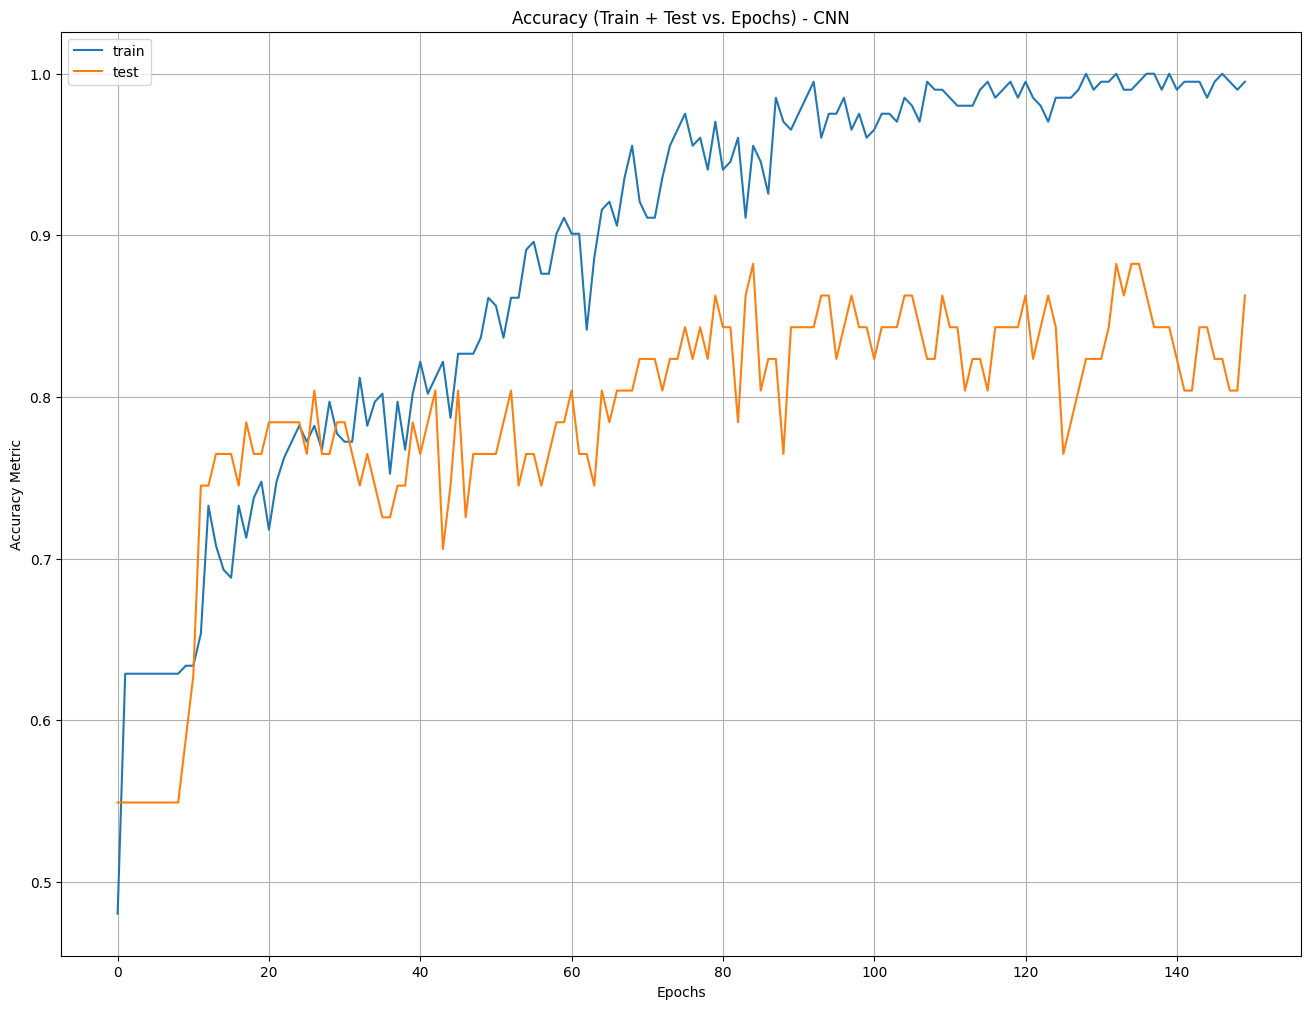

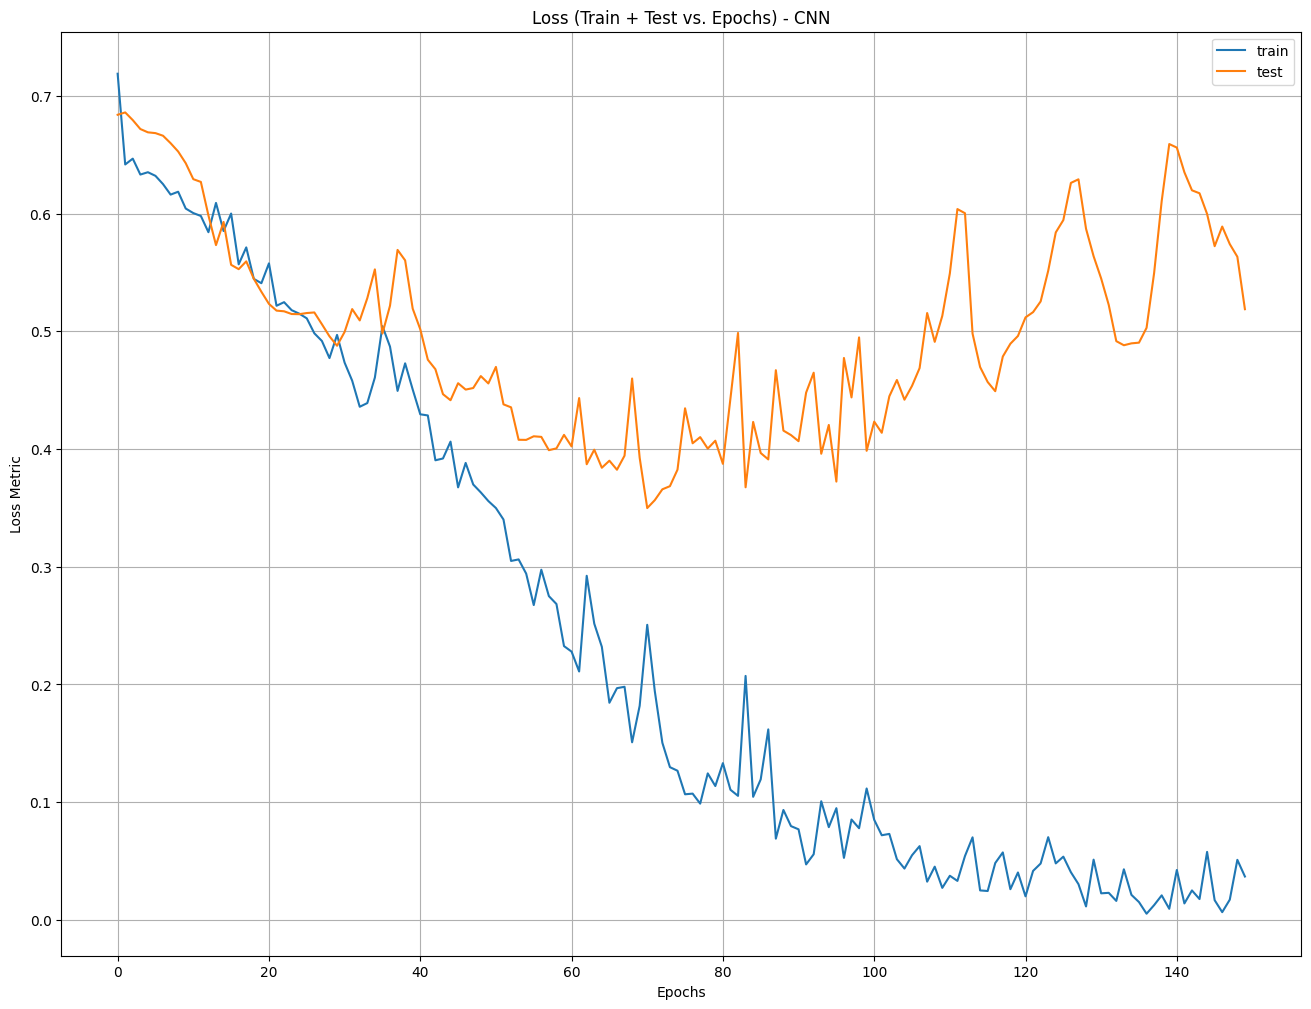

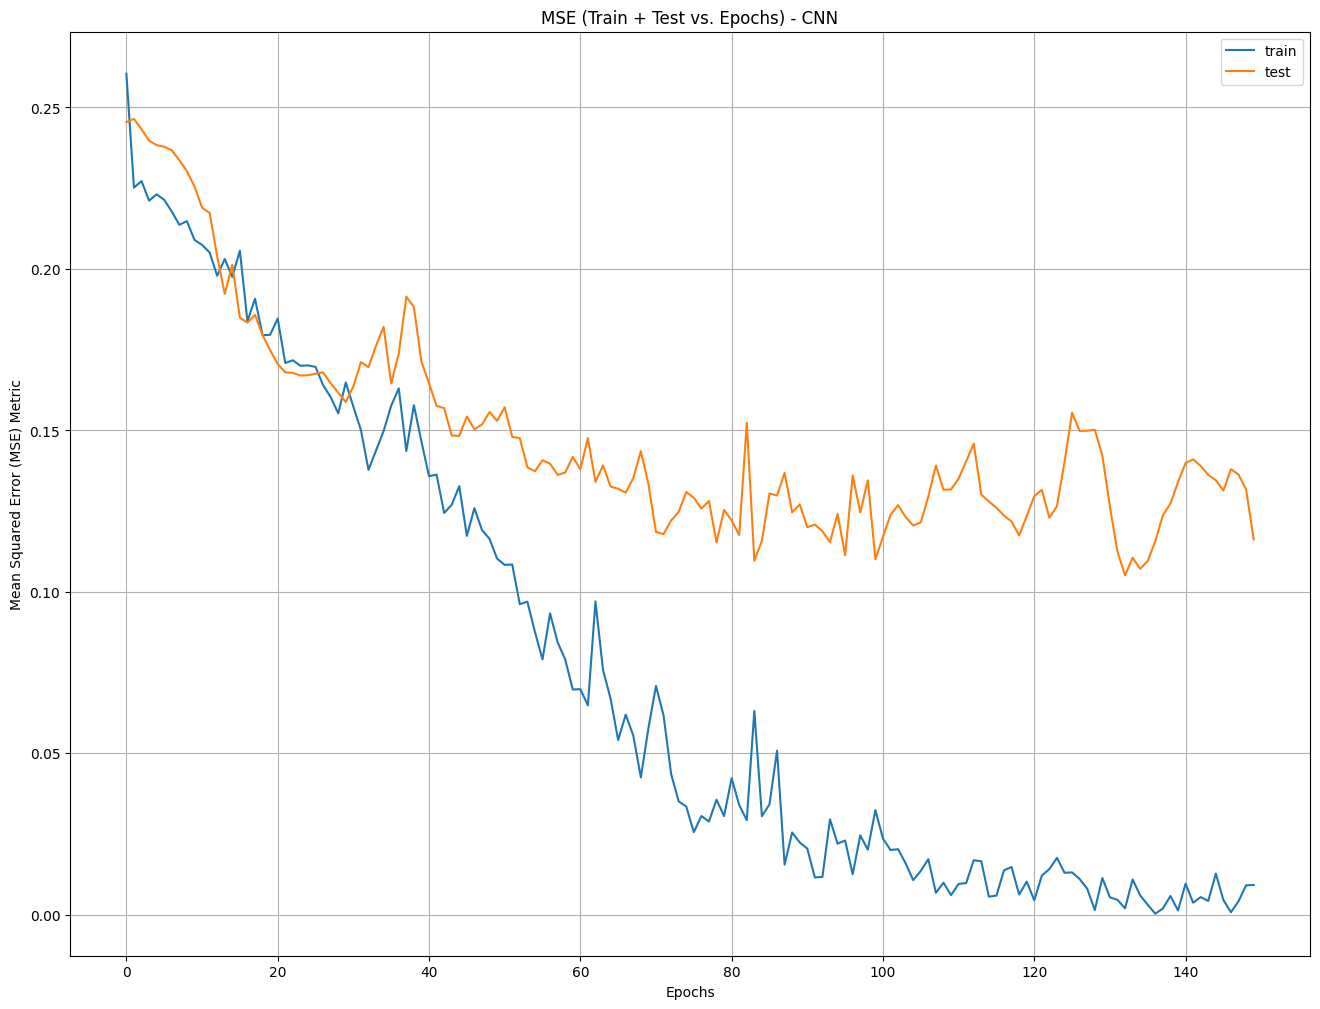

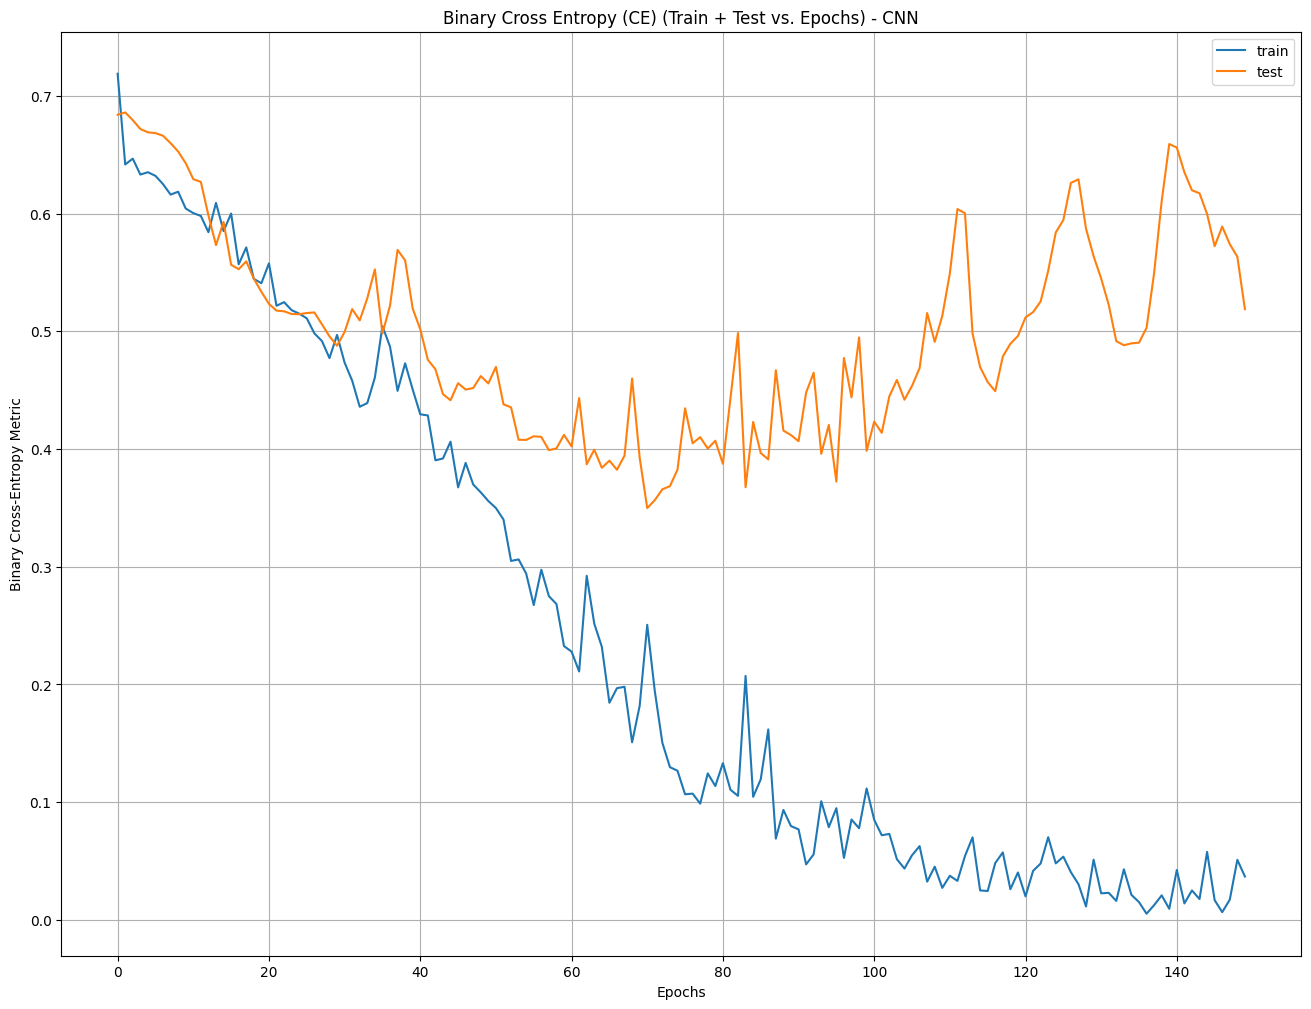

In [29]:
resultsaver_dir = "/content/drive/MyDrive/Undergraduate/SPRING 2023/CMPSC 442/CMPSC 442 Final Project - Group/Code - Colab Servers/Results/"

epochs_arr=np.arange(epochs_values[testable_epoch_idx])

y_acc_train=np.array(history.history["acc"])
y_loss_train=np.array(history.history["loss"])
y_mse_train=np.array(history.history["mean_squared_error"])
y_ce_train=np.array(history.history["binary_crossentropy"])

y_acc_test=np.array(history.history["val_acc"])
y_loss_test=np.array(history.history["val_loss"])
y_mse_test=np.array(history.history["val_mean_squared_error"])
y_ce_test=np.array(history.history["val_binary_crossentropy"])

#acc plot

fig = plt.figure(figsize = (16,12))

plt.plot(epochs_arr, y_acc_train, label="train") 
plt.plot(epochs_arr, y_acc_test, label="test")

plt.xlabel("Epochs")
plt.ylabel("Accuracy Metric")

plt.legend(loc='best')
plt.grid(True)

plt.title("Accuracy (Train + Test vs. Epochs) - CNN")

plt.savefig(resultsaver_dir+"acc_cnn.png")

#loss plot

fig = plt.figure(figsize = (16,12))

plt.plot(epochs_arr, y_loss_train, label="train") 
plt.plot(epochs_arr, y_loss_test, label="test")

plt.xlabel("Epochs")
plt.ylabel("Loss Metric")

plt.legend(loc='best')
plt.grid(True)

plt.title("Loss (Train + Test vs. Epochs) - CNN")

plt.savefig(resultsaver_dir+"loss_cnn.png")

#mse plot

fig = plt.figure(figsize = (16,12))

plt.plot(epochs_arr, y_mse_train, label="train") 
plt.plot(epochs_arr, y_mse_test, label="test")

plt.xlabel("Epochs")
plt.ylabel("Mean Squared Error (MSE) Metric")

plt.legend(loc='best')
plt.grid(True)

plt.title("MSE (Train + Test vs. Epochs) - CNN")

plt.savefig(resultsaver_dir+"mse_cnn.png")

# bce plot

fig = plt.figure(figsize = (16,12))

plt.plot(epochs_arr, y_ce_train, label="train") 
plt.plot(epochs_arr, y_ce_test, label="test")

plt.xlabel("Epochs")
plt.ylabel("Binary Cross-Entropy Metric")

plt.legend(loc='best')
plt.grid(True)

plt.title("Binary Cross Entropy (CE) (Train + Test vs. Epochs) - CNN")

plt.savefig(resultsaver_dir+"bce_cnn.png")


install svg to png converter

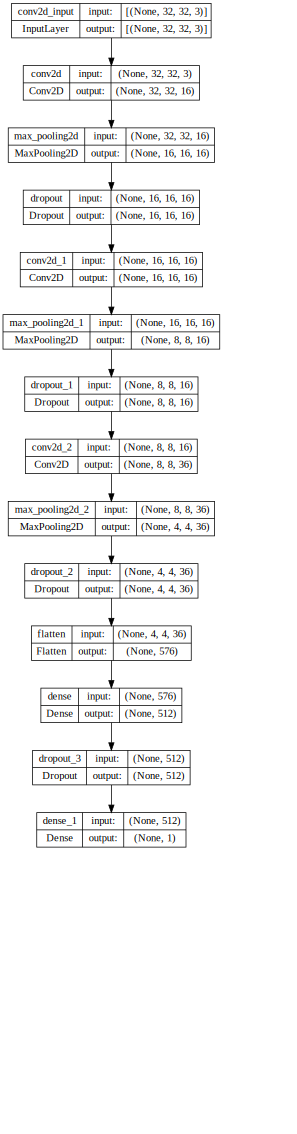

In [30]:
from IPython.display import SVG, display_png
from keras.utils.vis_utils import model_to_dot
from IPython.display import display
from PIL import Image

SVG(model_to_dot(model,show_shapes = True).create(prog='dot', format='svg'))


In [31]:
# Evaluate the model on test set
score = model.evaluate(x_test, y_test, verbose=0)

# Print test accuracy
print('\n', 'Test accuracy:', score[1])
print('\n', 'Test Binary Cross Entropy', score[2])
print('\n', 'Test Mean Squared Error:', score[3])


 Test accuracy: 0.8627451062202454

 Test Binary Cross Entropy 0.5187760591506958

 Test Mean Squared Error: 0.11622824519872665


In [32]:
labels =["Yes",  # index 0
        "No",      # index 1
        ]

2/2 [==============================] - 0s 4ms/step


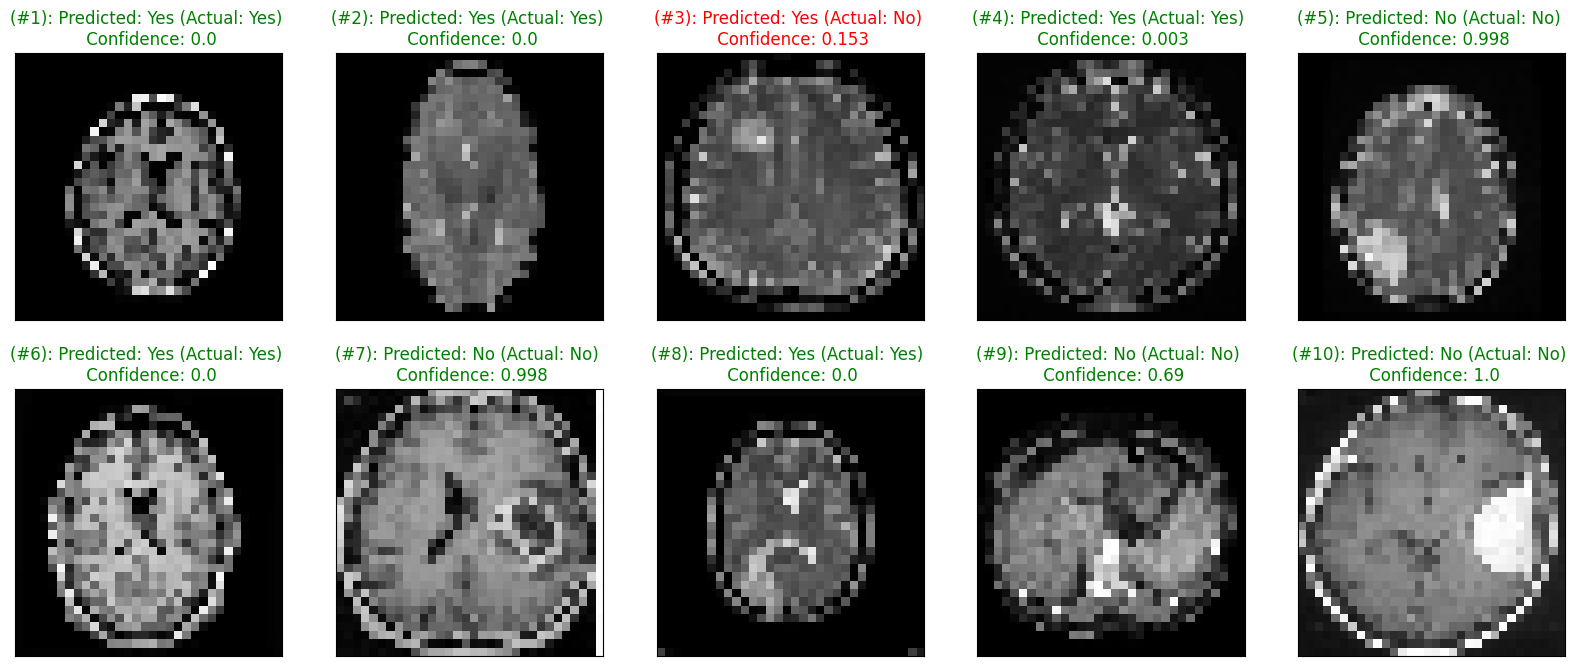

In [33]:
y_hat = model.predict(x_test)

# Plot a random sample of 10 test images, their predicted labels and ground truth
n_size=10
figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(x_test.shape[0], size=n_size, replace=False)):
    ax = figure.add_subplot(int(n_size/5), 5, i + 1, xticks=[], yticks=[])
    # Display each image
    ax.imshow(np.squeeze(x_test[index]))
    predict_index = int(np.round(y_hat[index][0]))
    true_index = int(np.round(y_test[index]))
    confidence_no=np.round(y_hat[index][0],3)
    # Set the title for each image
    ax.set_title("(#{}): Predicted: {} (Actual: {}) \n Confidence: {:.3}".format(i+1, labels[predict_index], 
                                  labels[true_index], confidence_no), 
                                  color=("green" if labels[predict_index]==labels[true_index] else "red"))

plt.savefig(resultsaver_dir+"random_validate_mris.png")

Further Stats

              precision    recall  f1-score   support

         Yes       0.83      0.87      0.85        23
          No       0.89      0.86      0.87        28

    accuracy                           0.86        51
   macro avg       0.86      0.86      0.86        51
weighted avg       0.86      0.86      0.86        51



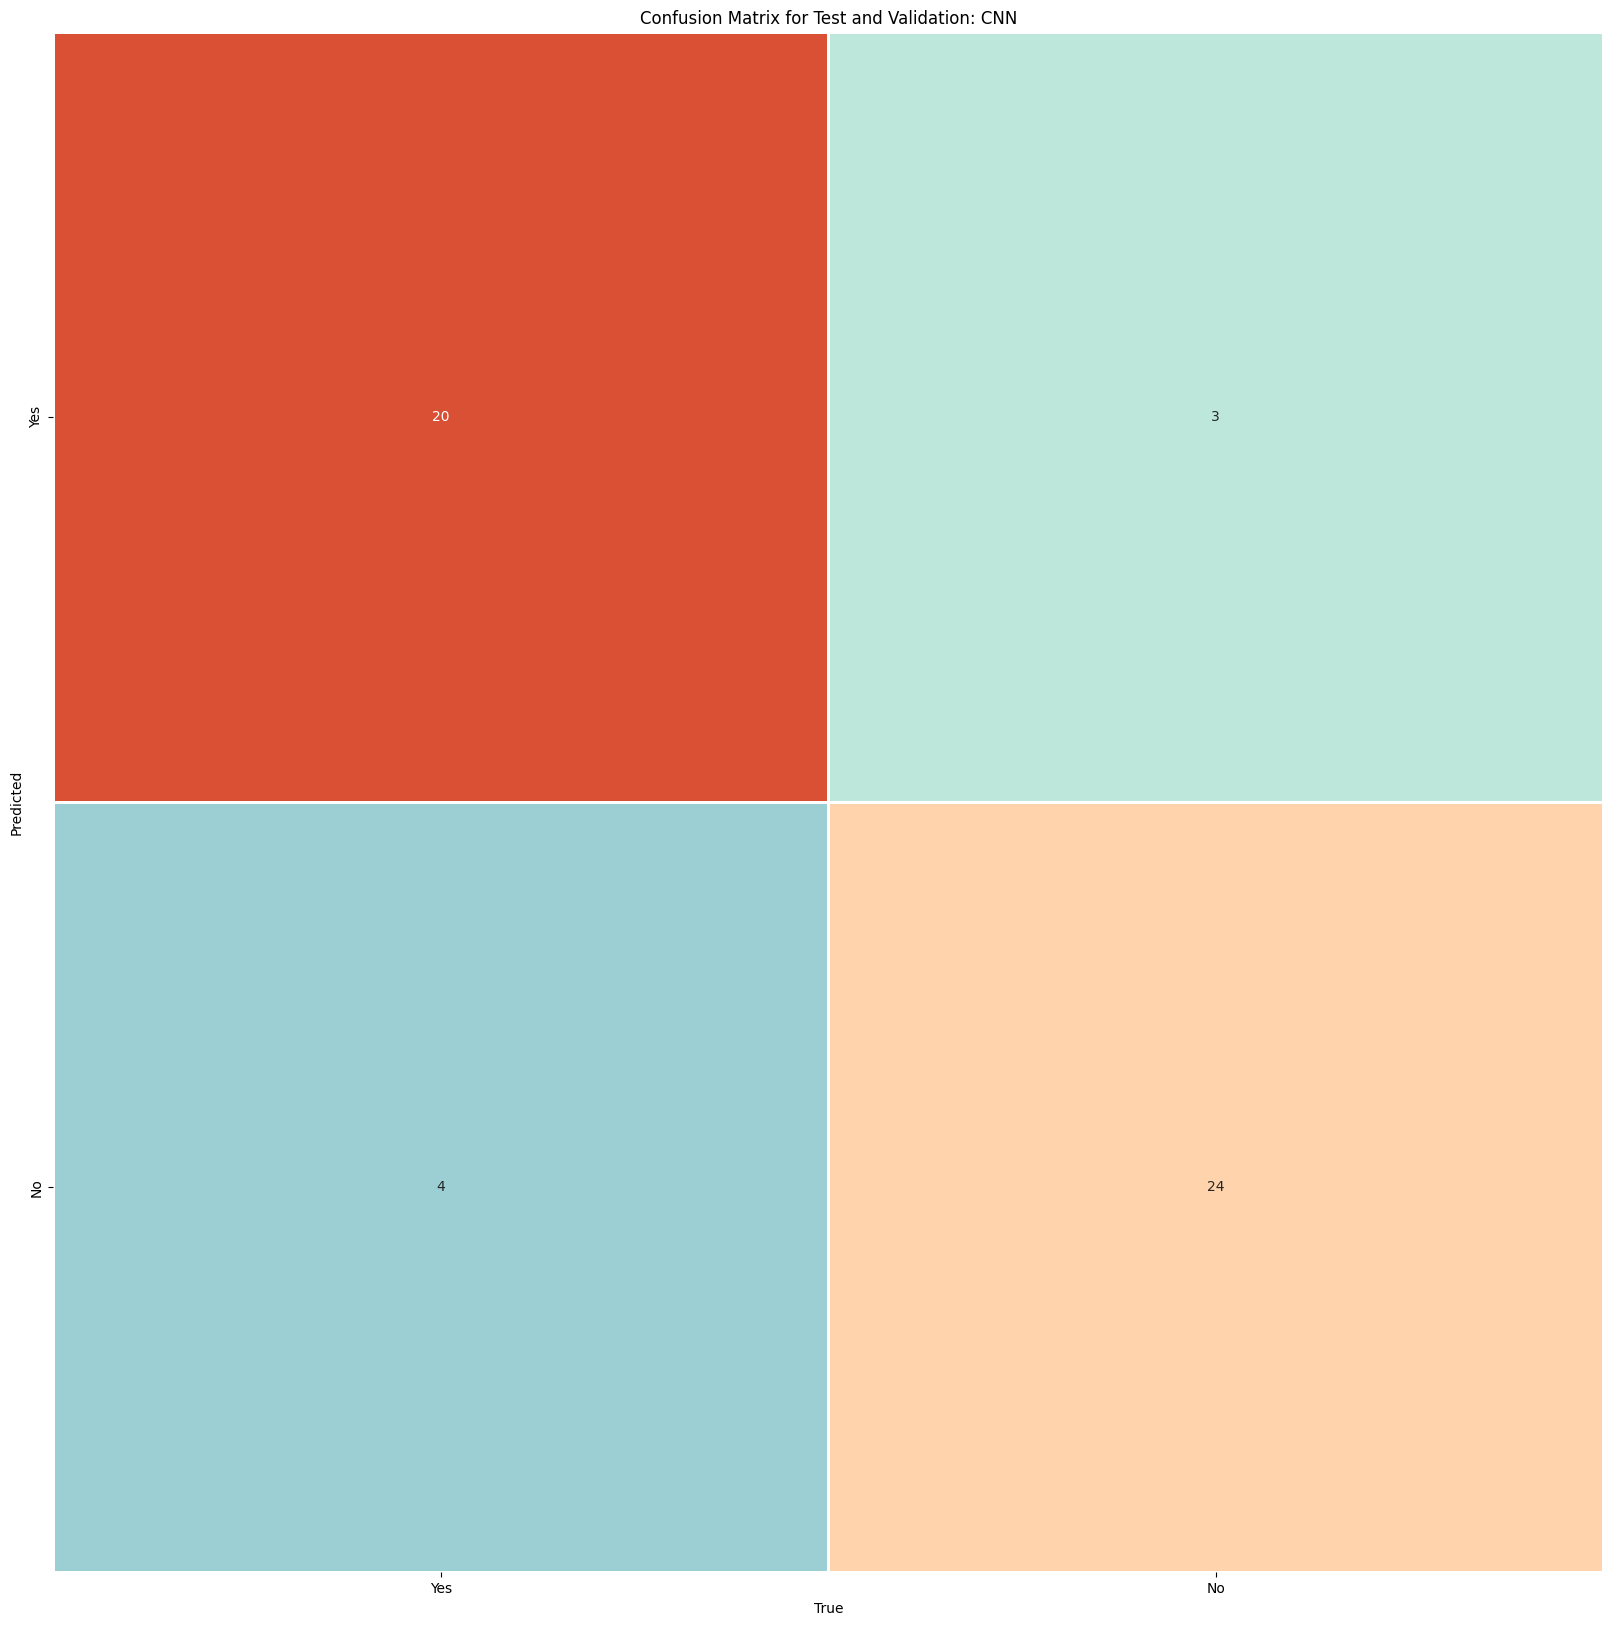

In [34]:
df_cm = confusion_matrix((np.round(y_test)),(np.round(y_hat.flatten())))

plt.figure(figsize = (20,20))

sns.heatmap(df_cm, annot=True, cmap="icefire", linewidths=1, cbar=False, xticklabels=labels, yticklabels=labels)

plt.xlabel("True")
plt.title("Confusion Matrix for Test and Validation: CNN")
plt.ylabel("Predicted")

plt.savefig(resultsaver_dir+"cm_cnn.png", dpi=100)

print(classification_report((np.round(y_test)),(np.round(y_hat.flatten())), target_names=labels))
